# Beaver Tutorial 2: Advanced Features (Data Owner)

**Features:** Output capture, live variables, reliable wait methods

Run this alongside `02-advanced-features-ds.ipynb` in a separate tab.

## Step 1: Setup

In [1]:
!uv pip install pandas matplotlib numpy -q

In [2]:
import beaver
from beaver import Twin

bv = beaver.ctx()
session = bv.active_session()
session.reset(force=True)

print(f"You: {bv.user}")
print(f"Peer: {session.peer}")

🔄 Auto-load replies enabled for client1@sandbox.local (polling every 0.5s)
🟢 Active session loaded: d9efe11cc2d0
   Peer: client2@sandbox.local
  Deleted: remote_vars.json
  Deleted: data/ (2 files)
✓ Session reset: 3 files deleted
You: client1@sandbox.local
Peer: client2@sandbox.local


## Step 2: Create Stock Data

In [3]:
import pandas as pd
import numpy as np

dates = pd.date_range('2024-01-01', periods=30, freq='D')

# Mock data (safe to share)
np.random.seed(42)
mock_stocks = pd.DataFrame({
    'AAPL': 150 + np.random.randn(30).cumsum() * 2,
    'GOOGL': 140 + np.random.randn(30).cumsum() * 2,
    'MSFT': 380 + np.random.randn(30).cumsum() * 3,
}, index=dates)

# Real data (sensitive)
np.random.seed(1337)
real_stocks = pd.DataFrame({
    'AAPL': 175 + np.random.randn(30).cumsum() * 3,
    'GOOGL': 165 + np.random.randn(30).cumsum() * 4,
    'MSFT': 420 + np.random.randn(30).cumsum() * 5,
}, index=dates)

print("Mock:", mock_stocks.shape)
print("Real:", real_stocks.shape)

Mock: (30, 3)
Real: (30, 3)


## Step 3: Publish Twin

In [4]:
stocks = Twin(public=mock_stocks, private=real_stocks, name="stocks")
session.remote_vars["stocks"] = stocks
print("Published 'stocks' twin!")


⚠️  Twin 'stocks' .public has unloaded data.
   Call .load() to load it, or approve now:
🌍 Loading PUBLIC data for Twin 'stocks'
   ✓ Loading data...
   ✓ Loaded: bytes
🌍 Using PUBLIC data from Twin 'stocks...'
📢 Published Twin 'stocks' (public side available at: /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0/data/3ecd5d10589b479cb2bc8d19bb5c78d1.beaver)
Published 'stocks' twin!


## Step 4: Wait for Analysis Request

**Run DS notebook Steps 1-4 now!**

In [5]:
request = bv.wait_for_request(stocks, timeout=300)
request

⏳ Waiting for request on 'stocks'...
📬 Request received: request_analyze_stocks_for_result
   From: client2@sandbox.local


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: analyze_stocks_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: analyze_stocks

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '5578681d...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=575d105f32c7... result=5f8c0476e253...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 5: Run and Approve

In [6]:
result = request.run_both()
print("Mock result:", result.data.public)
print("Real result:", result.data.private)
result.data.show_output("both")
result.approve()

🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
🔍 [post-execution] Figures to capture: 0
🔍 [post-execution] Already captured IDs: set()
🔒 Step 2/2: Executing on real/private data...
✓ Private result: dict
Mock result: {'mean': {'AAPL': 149.43254053315178, 'GOOGL': 133.8453373365875, 'MSFT': 380.31000159139916}, 'std': {'AAPL': 6.608426074041916, 'GOOGL': 4.555747397577688, 'MSFT': 3.844975241790074}, 'returns': {'AAPL': -8.134289150778095, 'GOOGL': -4.370665831104405, 'MSFT': 0.6860564350308485}}
Real result: {'mean': {'AAPL': 161.76203962932763, 'GOOGL': 172.7897777603486, 'MSFT': 400.05530438982765}, 'std': {'AAPL': 5.845337258141274, 'GOOGL': 7.50033652404769, 'MSFT': 10.8057291140962}, 'returns': {'AAPL': -13.159321692232925, 'GOOGL': -0.23861379852335488, 'MSFT': -7.100388177323206}}
📤 Public output:
  stdout: Analyzing 30 days of stock data...
Columns: ['AAPL', 'GOOGL', 'MSFT']

Returns:
  AAPL: -8.13%
  GOOGL: -4.37%
  MSFT: 0.69%

📤 Private output:
 

PosixPath('/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0/b517b554e9934da887c1a1c83284519b.beaver')

## Step 6: Live Variables Demo

In [7]:
import time

progress = Twin(public={"step": 0, "status": "starting"}, private=None, name="progress")
progress.enable_live(interval=1.0)
session.remote_vars["progress"] = progress

# Simulate work with progress updates
for i, msg in enumerate(["Loading...", "Processing...", "Analyzing...", "Done!"]):
    progress.public = {"step": i+1, "total": 4, "status": msg}
    session.remote_vars["progress"] = progress
    print(f"Step {i+1}/4: {msg}")
    time.sleep(2)

progress.disable_live()
print("\nComplete!")

🟢 Live sync enabled (read-only, every 1.0s)
🌍 Using PUBLIC data from Twin 'progress...'
📢 Published Twin 'progress' (public side available at: /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0/data/606ac25ea1734aafb1e36867c0c03325.beaver)
🌍 Using PUBLIC data from Twin 'progress...'
📢 Published Twin 'progress' (public side available at: /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0/data/6ac5ac0174d24eb08db8f833a4992b78.beaver)
Step 1/4: Loading...
🌍 Using PUBLIC data from Twin 'progress...'
  📢 Re-published to public registry
🌍 Using PUBLIC data from Twin 'progress...'
📢 Published Twin 'progress' (public side available at: /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9

## Step 7: Handle Plot Request

**Run DS notebook Step 7 now!**

In [8]:
plot_request = bv.wait_for_request(stocks, timeout=300)
plot_request

⏳ Waiting for request on 'stocks'...
📬 Request received: request_plot_stocks_for_plot_result
   From: client2@sandbox.local


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: plot_stocks_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: plot_stocks

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '5578681d...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=b9dbc08dcd2a... result=a5422b85c50a...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
🔍 [post-execution] Figures to capture: 1
🔍 [post-execution] Already captured IDs: {4912617264}
🔍 [post-execution] Fig: id=4912617264, already_captured=True
  ⏭️  Skipping (already captured)
🔒 Step 2/2: Executing on real/private data...
✓ Private result: dict
📊 Public figures (1):


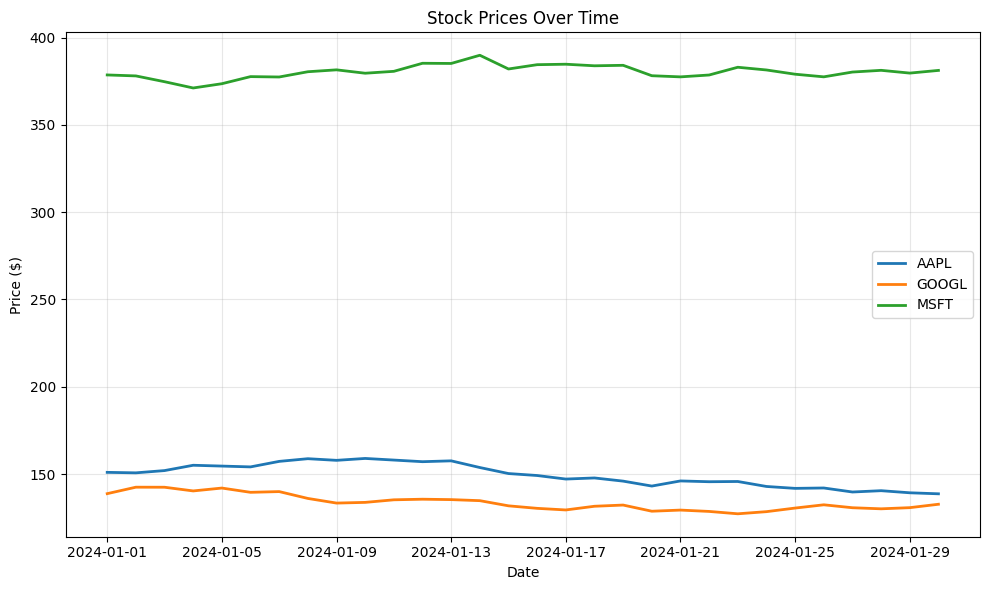

📊 Private figures (1):


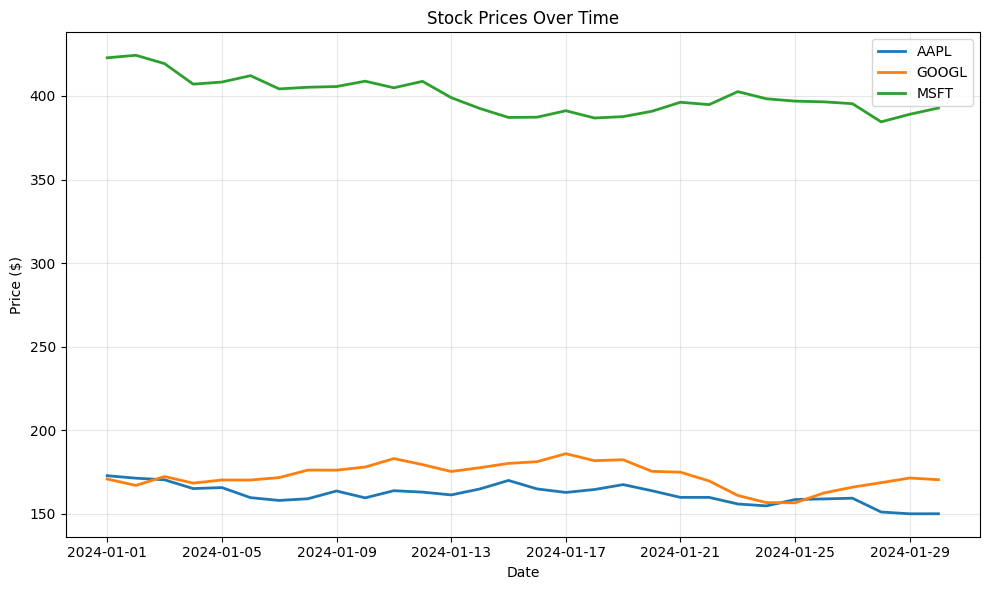

✅ Approving result for: plot_stocks_result (twin_id=a5422b85c50a..., comp_id=b9dbc08dcd2a..., result_id=a5422b85c50a)
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'plot_stocks_result...'
✓ Result sent to session folder: /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0
💡 They can load it with: bv.inbox()['plot_stocks_result'].load()
Plot result approved!


In [9]:
plot_result = plot_request.run_both()
plot_result.data.show_figures("both")
plot_result.approve()
print("Plot result approved!")

## Summary

- `wait_for_request(twin)` - Reliably wait for requests
- `.show_output()` / `.show_figures()` - View captured output
- `enable_live()` - Real-time variable sync